In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular

In [3]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M):
        self.phi = phi
        self.v = v
        self.M = M
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))

            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
        routes.append(Route(np.array(phi, dtype=np.float32), np.array(v, dtype=np.float32), np.array(M, dtype=np.float32)))
        allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque)

330394
16.049999237060547 34.94847106933594 1.0


Now we have everything stored in routes. Time to generate some test data

In [4]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [5]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 300
fwd_data = 100

input_length = 3 * prev_data + fwd_data

def get_sample(test):
    if test:
        route = routes[-1]
    else:
        route = routes[randrange(len(routes)-1)]

    idx = randrange(prev_data, len(route.v)-fwd_data)
    
    prev_angle = route.phi[idx-prev_data : idx]/maxAngle
    prev_speed = route.v[idx-prev_data : idx]/maxSpeed
    torque = route.M[idx-prev_data : idx+fwd_data]/maxTorque

    output = route.phi[idx+fwd_data-1 : idx+fwd_data]/maxAngle
    
    return prev_angle, prev_speed, torque, output

def caddy_dataset(length, test):
    i_data = []
    o_data = []
    for i in range(length):
        if i%(length//10) == 0:
            print(f"{i}/{length}")
        phi, v, M, o = get_sample(test)
        
        data_input = np.concatenate((phi, v, M))
        i_data.append(data_input)
        o_data.append(o)
    return SimDataset(length, i_data, o_data)


in_set = caddy_dataset(50000, False)
out_set = caddy_dataset(1000, True)

0/50000
5000/50000
10000/50000
15000/50000
20000/50000
25000/50000
30000/50000
35000/50000
40000/50000
45000/50000
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


In [6]:
train_dataloader = DataLoader(in_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(out_set, batch_size=64, shuffle=False)

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()*100
        print(f"Train loss: {loss}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*100

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

torch.Size([64, 1000])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
70337


In [9]:
epochs = 101
print(len(train_dataloader))
print(len(test_dataloader))
for t in range(epochs):
    if t%10 == 0:
        print(f"Epoch {t}")
    train_loop(train_dataloader, model, loss_fn, optimizer, t%10==0)
    if t%10 == 0:
        test_loop(test_dataloader, model, loss_fn)

781
16
Epoch 0
Train loss: 0.1951958518475294
Test  loss: 0.1537221614853479 



KeyboardInterrupt: 

In [20]:
random_sample = out_set[randrange(len(out_set))]
print(random_sample[0][599]*maxAngle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
print(model(torch_data_input).item()*maxAngle)

-7.349999985892623 initial angle
[-5.4]
-5.270848703173215


13.595516518203567 initial angle
[-6.15]
0.5977554616427625


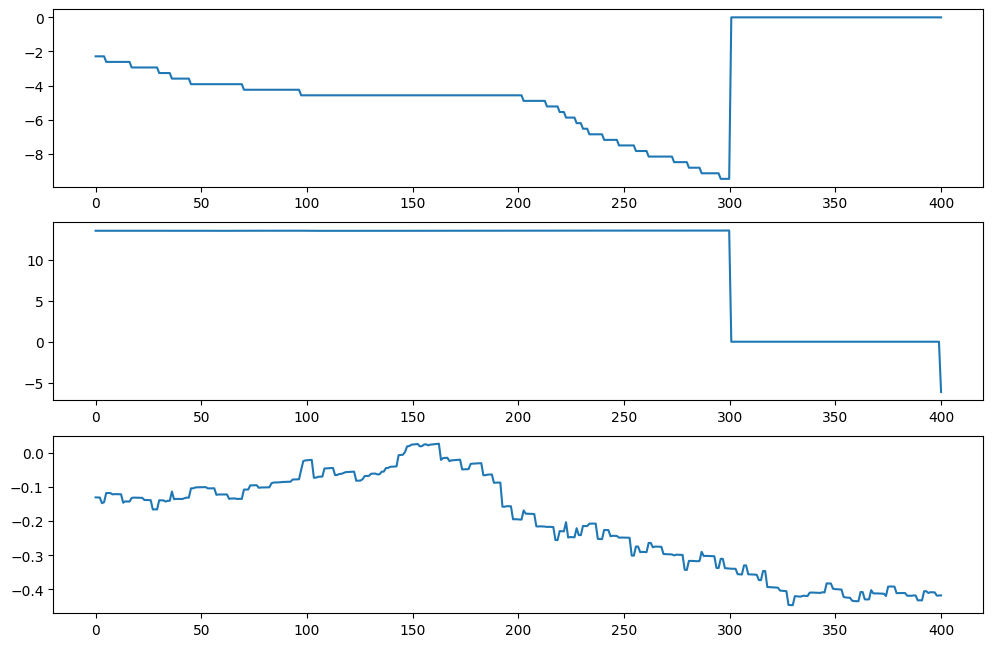

In [18]:
random_sample = out_set[randrange(len(out_set))]
i = random_sample[0]
v = i[0:300]*maxSpeed
phi = i[300:600]*maxAngle
M = i[600:1000]*maxTorque
v.resize(400)
phi.resize(400)
phi[-1] = random_sample[1][0]*maxAngle

time = 400
_, axs = plt.subplots(3)
axs[0].plot(np.linspace(0, time, time), v)
axs[1].plot(np.linspace(0, time, time), phi)
axs[2].plot(np.linspace(0, time, time), M)

print(random_sample[0][599]*maxAngle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
print(model(torch_data_input).item()*maxAngle)

In [23]:
torch.save(model, 'model.pth')

In [25]:
model = torch.load('model.pth')
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Tanh()
  )
)
